# QuarzNet

Reference paper: https://arxiv.org/pdf/1910.10261.pdf


## Architecture and Implementation

### I. Inconsitency with C1 and C2 blocks


#### Jasper
<img src="imgs/jasper_vertical.png" alt="Drawing" style="width: 400px;"/>


#### NEMO docs version
<img src="imgs/quartz_vertical.png" alt="Drawing" style="width: 400px;"/>



#### Paper version
<img src="imgs/qn_wrong.png" alt="Drawing" style="width: 400px;"/>

QuarzNet architecture is directly derived from Jasper architecture except that QuarzNet uses 1D time-channel separable convolutions (TCS) instead of usual convolutions to decrease the number of weight parameters and allow use of wider kernels.
Difference between 'paper' version and 'NEMO docs' version (referenced above) is in C1, C2 blocks.

According to the paper C1 is a block that has a kernel size of 33 and takes frequency (mel scale) as input and returns 256 channels as output.
If we use Conv-BN_ReLU block the dimensionality of weight parameters (assuming frequency to be 128) is $128 \times 33 \times 256$ (in_channels $\times$ kernel_size $\times$ out_channels) which adds up to $1 081 344$ parameters in C1 block. However, if we use TCSConv-BN-ReLU block (depthwise + pointwise convolution) we significantly decrease the number of parameters down to $128 \times 33 \times 1 = 4224$ (depthwise) and $128 \times 256 \times 1 = 32768$ (pointwise) and achieve anticipated result. The same logic applies to C2 block which contains even more parameters than C1 block due to a large kernel and larger input and output channel dimensions.

Model parameters suggested in the paper should be approximately equal to 6.7 millions for 5x3 model, so we decided to stick with the 'NEMO docs' version which in our opinion is a correct one.

### II. Implementation

Implementation was inspired by [FrancescoSaverioZuppichini](https://github.com/FrancescoSaverioZuppichini/ResNet) implementation of ResNet (there is a corresponding article on Medium).

Calculations of paddings to preserve dimensions was done according to the following formula:
    $$ \dfrac{W - F + 2P - (F - 1)(D - 1)}{S} + 1 = O $$ 
    where W is input dimension, F - receptive field (or kernel), P - padding, D - dilation, S - stride, O - output dimension

We perform downsampling in C1 block with stride 2, so for $S = 2, \ D = 1, \ O = \frac{W}{2} \implies P = \left\lceil \frac{F-2}{2} \right\rceil $

For $S = 1, \  D = 2, \ O = W \implies P = F - 1 $ – C2 block 

For $S = 1, \ D = 1, \ O = W \implies P = \left\lceil \frac{F - 1}{2} \right\rceil$ – all other blocks with such convolution parameters

__NB__: we use dilation in C2 block instead of C4 block as proposed in the paper because it makes more sense to use dilation in a block with kernel not being equal to one.

In [1]:
# all necessary imports for our model
from torch import nn
from typing import List
from math import ceil

We will use one helper function which is taken from [FrancescoSaverioZuppichini](https://github.com/FrancescoSaverioZuppichini/ResNet). The use of `*args` and `**kwargs` makes it easier to tweak Conv-Bn combination parameters further along.

In [2]:
def conv_bn(in_channels: int, out_channels: int, *args, **kwargs):
  return nn.Sequential(
    nn.Conv1d(in_channels, out_channels, *args, **kwargs),
    nn.BatchNorm1d(out_channels)
  )

#### Conv-Bn-ReLU Block

We will use inplace ReLU everywhere to decrease memory footprint.

In [3]:
class ConvBnReLUBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
    super(ConvBnReLUBlock, self).__init__()

    self.block = nn.Sequential(
      *conv_bn(in_channels, out_channels, *args, **kwargs),
      nn.ReLU(inplace=True)
    )

  def forward(self, X):
    return self.block(X)

#### TCS-Conv-Bn Block

This block is a combination of depthwise and pointwise convolution which is the main difference from Conv-Bn-ReLU block. We don't use `nn.ReLU` here to be able to apply residual connection in main block of model, which comes before activation function.

Deptwhise convolution applies convolution without changing channel dimensionality (that's why we use `group` parameter in `nn.Conv1d` function; kernel and padding are passsed from outside through `*args` and `**kwargs`).

Pointwise convolution has `kernel_size=1` and changes channel dimensionality.

In [4]:
class TCSConvBnBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
    super(TCSConvBnBlock, self).__init__()

    self.block = nn.Sequential(
      nn.Conv1d(in_channels, in_channels, groups=in_channels, *args, **kwargs), # depthwise
      *conv_bn(in_channels, out_channels, kernel_size=1, bias=False) # pointwise + norm
    )

  def forward(self, X):
    return self.block(X)

#### B1-B5 blocks

Residual layer is Pointwise convolution + BatchNorm
B1-B5 blocks are TCS-Conv-Bn-ReLU blocks with residual connections between them.

Implementation as `nn.ModuleList` is suitable for our purposes.

In [5]:
class MainBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
    super(MainBlock, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels

    self.blocks = nn.ModuleList(
      [TCSConvBnBlock(self._apply_first(i), out_channels, *args, **kwargs) for i in range(5)]
    )

    self.residual_layer = conv_bn(self.in_channels, self.out_channels, kernel_size=1)

  def _apply_first(self, index: int):
    return self.in_channels if index == 0 else self.out_channels

  def forward(self, X):

    residual = self.residual_layer(X)
    for index, unit_block in enumerate(self.blocks):
      X = unit_block(X)
      if index == len(self.blocks) - 1:
        X += residual
      X = nn.ReLU(inplace=True)(X)
    
    return X 

#### QuarzNet

C1-B1-B2-B3-B4-C2-C3-C4 connected blocks

`block_sizes` and `kernels` correspond to outputs dimensions and kernels of B1-B5 bocks and C2 block

`multiplier` corresponds to number of TCS-Conv-Bn-ReLU blocks in B-type blocks. Helps to define depth of QuarzNet models (5x3, 10x3 or 15x3)

In [6]:
class QuarzNet(nn.Module):
  def __init__(self, n_mels: int, labels: int, block_sizes: List[int]=[256, 256, 512, 512, 512, 512], kernels: List[int]=[33, 39, 51, 63, 75, 87], multiplier: int=1):
    super(QuarzNet, self).__init__()

    # C1 Block: Downsampling, stride = 2, padding = ceil((K - 2) / 2)
    self.conv1 = nn.Sequential(
      TCSConvBnBlock(n_mels, block_sizes[0], kernel_size=kernels[0], stride=2, padding=int(ceil((kernels[0] - 2) / 2)), bias=False),
      nn.ReLU(inplace=True)
    )

    current_in_channels = block_sizes[0]

    # B1-B5 Blocks: each BxR TCSConv-Bn-ReLU with residual connections, B=multiplier, R=5
    # padding maintains separate time channel width
    self.main_blocks = nn.ModuleList()

    for i in range(5):
      for j in range(multiplier):
        self.main_blocks.append(
          MainBlock(current_in_channels, block_sizes[i], kernel_size=kernels[i], padding=int(ceil((kernels[i] - 1) / 2)), bias=False)
        )
        current_in_channels = block_sizes[i] # sequentially update in_channels
    
    # C2 Block
    self.conv2 = nn.Sequential(
      TCSConvBnBlock(current_in_channels, block_sizes[5], kernel_size=kernels[5], dilation=2, padding=kernels[5]-1, bias=False),
      nn.ReLU(inplace=True)
    )

    current_in_channels = block_sizes[5]

    # C3 Block
    self.conv3 = ConvBnReLUBlock(current_in_channels, current_in_channels * 2, kernel_size=1, bias=False)

    # C4 Block
    self.conv4 = ConvBnReLUBlock(current_in_channels * 2, labels, kernel_size=1, bias=False)

  def forward(self, X):
    X = self.conv1(X)
    for block in self.main_blocks:
      X = block(X)
    X = self.conv2(X)
    X = self.conv3(X)
    X = self.conv4(X)
    return X

In [7]:
def QuarzNet5x3(n_mels:int, labels:int):
  return QuarzNet(n_mels=n_mels, labels=labels, multiplier=1)

def QuarzNet10x3(n_mels:int, labels:int):
  return QuarzNet(n_mels=n_mels, labels=labels, multiplier=2)

def QuarzNet15x3(n_mels:int, labels:int):
  return QuarzNet(n_mels=n_mels, labels=labels, multiplier=3)

Let's check that model parameters are the same as in paper and output summary about it assuming that `n_mels=128` for spectrograms and we use English alphabet with spaces and apostrophe and one blank token (`labels=29`)

In [8]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchsummary import summary

In [10]:
model = QuarzNet5x3(n_mels=128, labels=29)
summary(model, (128, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 512]           4,224
            Conv1d-2             [-1, 256, 512]          32,768
       BatchNorm1d-3             [-1, 256, 512]             512
    TCSConvBnBlock-4             [-1, 256, 512]               0
              ReLU-5             [-1, 256, 512]               0
            Conv1d-6             [-1, 256, 512]          65,792
       BatchNorm1d-7             [-1, 256, 512]             512
            Conv1d-8             [-1, 256, 512]           8,448
            Conv1d-9             [-1, 256, 512]          65,536
      BatchNorm1d-10             [-1, 256, 512]             512
   TCSConvBnBlock-11             [-1, 256, 512]               0
           Conv1d-12             [-1, 256, 512]           8,448
           Conv1d-13             [-1, 256, 512]          65,536
      BatchNorm1d-14             [-1, 2

In [11]:
model = QuarzNet10x3(n_mels=128, labels=29)
summary(model, (128, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 512]           4,224
            Conv1d-2             [-1, 256, 512]          32,768
       BatchNorm1d-3             [-1, 256, 512]             512
    TCSConvBnBlock-4             [-1, 256, 512]               0
              ReLU-5             [-1, 256, 512]               0
            Conv1d-6             [-1, 256, 512]          65,792
       BatchNorm1d-7             [-1, 256, 512]             512
            Conv1d-8             [-1, 256, 512]           8,448
            Conv1d-9             [-1, 256, 512]          65,536
      BatchNorm1d-10             [-1, 256, 512]             512
   TCSConvBnBlock-11             [-1, 256, 512]               0
           Conv1d-12             [-1, 256, 512]           8,448
           Conv1d-13             [-1, 256, 512]          65,536
      BatchNorm1d-14             [-1, 2

In [12]:
model = QuarzNet15x3(n_mels=128, labels=29)
summary(model, (128, 1024))

, 512]               0
           Conv1d-58             [-1, 256, 512]           8,448
           Conv1d-59             [-1, 256, 512]          65,536
      BatchNorm1d-60             [-1, 256, 512]             512
   TCSConvBnBlock-61             [-1, 256, 512]               0
           Conv1d-62             [-1, 256, 512]           8,448
           Conv1d-63             [-1, 256, 512]          65,536
      BatchNorm1d-64             [-1, 256, 512]             512
   TCSConvBnBlock-65             [-1, 256, 512]               0
           Conv1d-66             [-1, 256, 512]           8,448
           Conv1d-67             [-1, 256, 512]          65,536
      BatchNorm1d-68             [-1, 256, 512]             512
   TCSConvBnBlock-69             [-1, 256, 512]               0
           Conv1d-70             [-1, 256, 512]           8,448
           Conv1d-71             [-1, 256, 512]          65,536
      BatchNorm1d-72             [-1, 256, 512]             512
   TCSConvBnBlock

Indeed they match expected 6.7M for `QuarzNet5x3`, 12.8M for `QuarzNet10x3` and 18.9M for `QuarzNet15x3`

## Experiments

### I. Problem statement

In [15]:
# can be changed to pip if run on colab
!pip3 install -qq torchaudio
!pip3 install -qq torch_optimizer
!pip3 install -qq editdistance
!pip3 install -qq git+https://github.com/albumentations-team/albumentations.git

^C
ERROR: Operation cancelled by user


In [16]:
import torchaudio
import torch
from torchaudio.transforms import MelSpectrogram
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import string
from typing import List
import editdistance

For experiments we will use [LibriSpeech Dataset](https://www.openslr.org/12). Here we will use `dev-clean` and `test-clean` datasets for presenting some functions. For training in another notebook we used `train-clean-100` dataset due to memory and compute power restrictions. In this notebook we will only present results.
Folders `model` and `utils` contain code that was used for collating data and preparing it for training.

Preparing data and training was heavily inspired by these open-source implementations:
- https://github.com/isadrtdinov/quartznet
- https://github.com/oleges1/quartznet-pytorch
- https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch (not quarznet, but another ASR Model)

Logging was done in `wandb` to save results and also was insipred by above-mentioned implementations.
Unfortunately, training time is quite long, so we didn't test everything and achieve *ok* results.


Download dataset

In [17]:
train_ls_dev = torchaudio.datasets.LIBRISPEECH(root="./", url="dev-clean", download=True)
test_ls_dev = torchaudio.datasets.LIBRISPEECH(root="./", url="test-clean", download=True)

QuarzNet takes as input a spectrogram and outputs (after applying softmax) posterior probabilities of tokens to be used for `CTCloss` computation.

More on CTCLoss here:
- [Original paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf)
- [Nice Explanation](https://distill.pub/2017/ctc/)

CTCLoss takes four arguments: spectrogram, target (indexed utterance), input_length (spectrogram time dimension length), target_length (utterance length).

In file `TextTransforms.py` we initialize alphabet consisting of English letters, space and apostrophe (`class TextTransforms`). For CTCloss we also introduce a blank token, so in total we have 29 labels on which our model will be trained. In function `greedy_decode_path` we perform greedy decoding of output by cutting it to original utterance length, removing consecutive indices and then removing blank token and converting it back to string.
When validating we compute WER and CER by passing it to corresponding functions in `metrics.py`. In the first case it is Levenshtein distance computed on hashable object and divided by number of words in original utterance. In the latter it is also Levenshtein distance computed on whole string and divided by number of chars in it.

In file `DataTransforms.py` there is a callable class `DataCollate` used as an argument passed to `collate_fn` in Dataloader. It processes batch, applies augmentations (such as SpecCut or SpecAug)

Here are these functions:


In [18]:
# TextTransforms.py
class TextTransform:
  def __init__(self, alphabet="'" + ' ' + string.ascii_lowercase):
    self.alphabet = alphabet
    self.int2char = dict(enumerate(alphabet))
    self.char2int = {val: key for (key, val) in self.int2char.items()}

  def text_to_int(self, text: str):
    text = text.lower()
    encoded_sequence = list(map(lambda symbol: self.char2int[symbol], text))
    return encoded_sequence

  def int_to_text(self, tokens: List[int]):
    decoded_sequence = list(map(lambda token: self.int2char[token], tokens))
    return ''.join(decoded_sequence)

def greedy_path_search(text_transform: TextTransform, hypothesis: torch.Tensor, reference: torch.Tensor, seq_length: int, blank: int=28):
  hypothesis, reference = hypothesis[:seq_length], reference[:seq_length]
  hypothesis = torch.unique_consecutive(hypothesis)
  hypothesis = hypothesis[hypothesis != blank]
  return text_transform.int_to_text(hypothesis.tolist()), text_transform.int_to_text(reference.tolist())

In [19]:
# metrics.py
def WER(hypothesis:List[str], reference:List[str]) -> int:
  return float(editdistance.eval(hypothesis, reference)) / len(reference)

def CER(hypothesis: str, reference: str) -> float:
  return float(editdistance.eval(hypothesis, reference)) / len(reference)

In [20]:
# DataCollate
class DataCollate:
  def __init__(self, sr=16000, n_mels=128, audio_aug=None, specAug=None, specCut:bool=None, holes:int=24):
    self.sr = sr
    self.transform = torchaudio.transforms.MelSpectrogram(
      n_fft=1024,
      sample_rate=self.sr,
      n_mels=n_mels,
      win_length=1024,
      hop_length=256,
    )
    self.spec_aug = nn.Sequential(
      torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
      torchaudio.transforms.TimeMasking(time_mask_param=50)
    ) if specAug else None
    self.cutout = specCut
    self.text_transform = TextTransform()
    self.audio_aug=audio_aug
    self.holes = holes


  def __call__(self, ls_batch):
    spectrograms = []
    input_lengths = []
    targets = []
    target_lengths = []

    for waveform, _, utterance, _, _, _ in ls_batch:
      if self.audio_aug:
        waveform, self.sr = torchaudio.sox_effects.apply_effects_tensor(waveform, self.sr, self.audio_aug, channels_first=True)
        self.transform.sample_rate = self.sr
      
      mspec = torch.log(self.transform(waveform).clamp(1e-5)).squeeze(0)
      if self.cutout:
        np_spec = A.CoarseDropout(max_holes=self.holes, min_height=4, max_height=16, min_width=4, max_width=16, p=0.9)(image=mspec.cpu().numpy())['image']
        mspec = torch.from_numpy(np_spec)
      mspec = mspec.transpose(0,1)

      if self.spec_aug:
        mspec = self.spec_aug(mspec)

      spectrograms.append(mspec)
      input_lengths.append(mspec.shape[0] // 2)
      targets.append(torch.Tensor(self.text_transform.text_to_int(utterance)))
      target_lengths.append(len(targets[-1]))


    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).transpose(1,2)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)

    return spectrograms, targets, input_lengths, target_lengths

#### Augmentations

In [21]:
spec_transform = MelSpectrogram(n_mels=128, n_fft=1024, win_length=1024, hop_length=256)
sample_spectrogram = torch.log(spec_transform(train_ls_dev[0][0]).clamp(1e-5)).squeeze(0)

#### Spectral Augmentation

In [22]:
spec_aug = nn.Sequential(
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
    torchaudio.transforms.TimeMasking(time_mask_param=50)
)

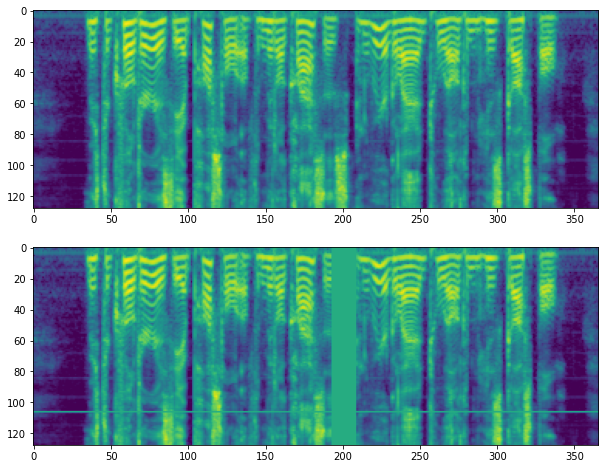

In [23]:
fig, axes = plt.subplots(2, figsize=(16, 8))
axes[0].imshow(sample_spectrogram.numpy())
axes[1].imshow(spec_aug(sample_spectrogram.clone()).numpy())

#### Spectral Cutout

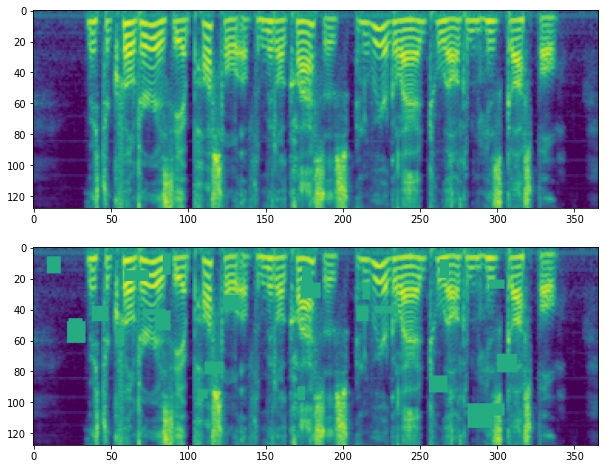

In [24]:

np_sample_spectrogram = A.CoarseDropout(max_holes=24, min_height=4, max_height=16, min_width=4, max_width=16, p=0.9)(image=sample_spectrogram.cpu().numpy())['image']
fig, axes = plt.subplots(2, figsize=(16, 8))
axes[0].imshow(sample_spectrogram.numpy())
axes[1].imshow(np_sample_spectrogram)

For training and validating we tried using mixed precision. Unfortunately, we don't possess multiple gpu nodes. Still, using automatic mixed precision from pytorch via `torch.cuda.amp.autocast` and `GradScaler` improves training speed a little. However, it may negatively affect results. We haven't tried training without mixed precision. 

In train function we accumulate train loss. In validation function we accumulate validation loss, wer and cer.

Train and validation function look as follows:

In [25]:
def trainEpoch(train_dataloader, model, criterion, optimizer, scheduler, scaler, epoch: int, device='cuda:0'):
  model.train()
  criterion_loss = []
  for (i, data) in enumerate(train_dataloader):
    spectrogram, targets, input_lengths, target_lengths = data
    spectrogram, targets = spectrogram.to(device), targets.to(device)

    optimizer.zero_grad(set_to_none=True)

    with torch.cuda.amp.autocast():
      log_probs = nn.functional.log_softmax(model(spectrogram), dim=1)
      loss = criterion(log_probs.permute(2, 0, 1), targets, input_lengths, target_lengths)

    criterion_loss.append(loss.item())
    
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scheduler.step()
    scaler.update()

  avg_loss = sum(criterion_loss) / len(criterion_loss)
  wandb.log({'train_loss': avg_loss})
  print(f"Train Epoch[{epoch}]. loss: {avg_loss} ")

  return avg_loss

In [26]:
@torch.no_grad()
def testEpoch(test_dataloader, model, criterion, scaler, epoch: int, device='cuda:0'):
    model.eval()
    criterion_loss = []
    wer = []
    cer = []
    for i, data in enumerate(test_dataloader):
      spectrogram, targets, input_lengths, target_lengths = data
      spectrogram, targets = spectrogram.to(device), targets.to(device)

      with torch.cuda.amp.autocast():
        log_probs = nn.functional.log_softmax(model(spectrogram), dim=1)
        loss = criterion(log_probs.permute(2, 0, 1), targets, input_lengths, target_lengths)

      scaler.scale(loss)
      criterion_loss.append(loss.item())
      

      sequences = log_probs.argmax(1)
      for k, target in enumerate(targets):
        hypothesis, reference = greedy_path_search(TextTransform(), sequences[k], target, target_lengths[k])
        cur_wer = WER(hypothesis.split(), reference.split())
        cur_cer = CER(hypothesis, reference)
        wer.append(cur_wer)
        cer.append(cur_cer)
        

    avg_loss = sum(criterion_loss) / len(criterion_loss)
    avg_wer = sum(wer) / len(wer)
    avg_cer = sum(cer) / len(cer)
    wandb.log({
        'test_loss': avg_loss,
        'WER': avg_wer,
        'CER': avg_cer
    })
    print(f"Test Epoch[{epoch}]. loss: {avg_loss}; wer: {avg_wer}; cer: {avg_cer} ")

    return avg_loss, avg_wer

### II. Results

We tried to replicate training process proposed in original paper.

We used QuarzNet5x3 model, criterion – CTCLoss, as optimizer we used `Novograd` from `torch_optimizer` library, scheduler – Cosine Annealing with Warm Restarts.

We will provide another notebook which was used for training.


Metrics

<img src="imgs/trloss.png" alt="Drawing"/>
<img src="imgs/tloss.png" alt="Drawing"/>
<img src="imgs/wer.png" alt="Drawing"/>
<img src="imgs/cer.png" alt="Drawing"/>

Due to incorrect `wandb` setup each epoch is logged once in two steps. That's why we have approximately 80 steps on x-axis.

Best wer that we managed to achieve was 0.70 when trying to continue training on `qn-128-001-aug-3232-2` which is `qn-128-001-aug-3232-2-cont` in the presented graphs. It was approximately after 40 epochs of training which took more than 5 hours (which was actually quite hard to achieve due to different colab disconnections).

Explanations:
128 stands for `n_mels`, 001 or 0.01 – learning rate, aug - augmentations, 3232 - batch sizes for training and test (32 and 32 respectively), cut – cutout.

Almost all models were trained on betas of (0.95, 0.5) and on learning rates of 0.01 or 0.015, with weight decay of 0.001.

Warmup period for chosen scheduler was 1000 iteration.

We tried increasing learning rate, but even with 0.03 or 0.05 loss went to nan.

We can see test_loss, wer and cer exhibiting the same oscillating pattern which is tied up to warmup period. We believe that problem with increasing metrics on validation are to lack of data. Even `train-clean-100` dataset is quite small. Probably, we could have achieved better regularization and no overfitting with replicating dataset and applying speech perturbation (10 percent) which was suggested both in paper and [here](https://github.com/NVIDIA/NeMo/issues/230) by NEMO developers.

Unfortunately, we didn't have much time and resources to check whether wer and cer slowly drop while oscillating. Smaller Beta2 and greater batch size with decrease of `n_mels` led to unstable training, which is shown by `qn-64-0015-cut-12832`.

As a result we want to say that to achieve SOTA results it took much more epochs, much more compute power to train the best model (which is QuarzNet15x3, which we also tried to train, but it appeared to be too long to be done on Google Colab).

We didn't do much experiments comparing it to other ASR models which can be done by using NEMO framework and using their pretrained models.

From our experiments and lack of comparison we cannot surely say whether QuarzNet performance is significantly better than of other models based on CNNs or Attention.

Still QuarzNet low number of parameters allows to train model quite fast (having significant compute power) and it can be used for ASR tasks quite successfully.

